In [1712]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as sciint
from functools import partial

# Mine
from wilson_cowan_2d.systems.concrete_solvers import UVRK4, WZRK4
from wilson_cowan_2d.systems import concrete_wc_kernel as wck
from wilson_cowan_2d.kernels import decreasing_exponential, Dist1DGrid
from wilson_cowan_2d.kernels.kernels import make_K_2_populations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2211]:
τe = 1
τi = 0.6 * τe

param = wck.DefaultParams(τ = np.array([τe, τi]), η = 0.1, size = 2**8)
# param.A = np.array([[1, 1.5],[1, 0.25]])
# param.F = lambda x: 1/(1 + np.exp(-50 * x))
param.Θ = np.array([0.08, 0.4])
# param.Θ = np.array([0.125, 0.4])
# param.Θ = np.array([0.1, 0.35])
# param.β = 50


In [2212]:
def calc_bs(param, u_bar, v_bar):
    return param.A * derv_F(param, u_bar, v_bar).reshape(2, 1)

def derv_F(param, u_bar, v_bar):
    ss = ss_F(param, u_bar, v_bar)
    return param.β * ss*(1 - ss)

def ss_F(param, u_bar, v_bar):
    return param.F(param.A[:, 0]*u_bar - param.A[:,1]*v_bar - param.Θ)

In [2213]:
ss_F(param, 1, 1)

array([2.54366565e-13, 9.99999975e-01])

In [2214]:
derv_F(param, 1, 1)

array([1.27183282e-11, 1.25549952e-06])

In [2215]:
param.A * derv_F(param, 0.25, 0.5).reshape(2,1)

array([[1.27183282e-11, 1.90774924e-11],
       [5.33850865e-05, 1.33462716e-05]])

In [2216]:
calc_bs(param, 0.25, 0.3)

array([[4.15763668e-05, 6.23645502e-05],
       [6.50347964e-04, 1.62586991e-04]])

In [2217]:
u_bar = 0.25
v_bar = 0.5

# e,e
tt = param.F(param.A[0,0]*u_bar - param.A[0,1]*v_bar - param.Θ[0])
ee = param.A[0,0] * param.β * tt * (1 - tt)

# e, i
tt = param.F(param.A[0,0]*u_bar - param.A[0,1]*v_bar - param.Θ[0])
ei = param.A[0,1] * param.β * tt * (1 - tt)

# i, e
tt = param.F(param.A[1,0]*u_bar - param.A[1,1]*v_bar - param.Θ[1])
ie = param.A[1,0] * param.β * tt * (1 - tt)

# i, e
tt = param.F(param.A[1,0]*u_bar - param.A[1,1]*v_bar - param.Θ[1])
ii = param.A[1,1] * param.β * tt * (1 - tt)
print(ee, ei)
print(ie, ii)

1.2718328236878189e-11 1.907749235531728e-11
5.338508650273632e-05 1.334627162568408e-05


In [2218]:
bs = calc_bs(param, 0.4, 0.2)

def calc_D0(u_bar, v_bar, param):
    bs = calc_bs(param, u_bar, v_bar)
    return (1 - bs[0,0])*(1 + bs[1,1]) + bs[0,1]*bs[1,0]

# def calc_Dω(ω, u_bar, v_bar, param):
    

In [2219]:
xx, yy = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

In [2220]:
bs = calc_bs(param, xx[0,0], yy[0,0])

In [2221]:
rang = np.linspace(0,1,100)

mesh = np.array([[calc_D(x, y, param) for x in rang] for y in rang])

np.where(mesh == np.max(mesh))

(array([25]), array([46]))

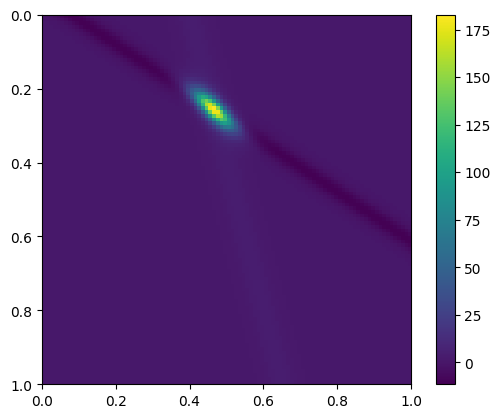

In [2222]:
_ = plt.imshow(mesh, extent=[0,1,1,0])
plt.colorbar()

In [2223]:
parm_calc_D = partial(calc_D, param=param)

In [2224]:
res = opt.minimize(lambda inp: -parm_calc_D(inp[0], inp[1]), (0.4, 0.2))

In [2225]:
u_bar, v_bar = res.x
print(u_bar, v_bar)

0.4639999607420713 0.25599996254515983


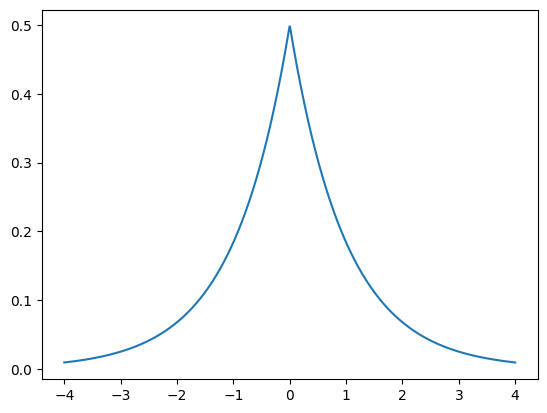

In [2111]:
lim = 4
xx = np.linspace(-lim, lim, 1_000)
de = decreasing_exponential(np.abs(xx), 1)
plt.plot(xx, de)

In [2112]:
de = [decreasing_exponential(np.abs(xx), x) for x in range(1,10)]
de = [x/x.sum() for x in de]

501 500


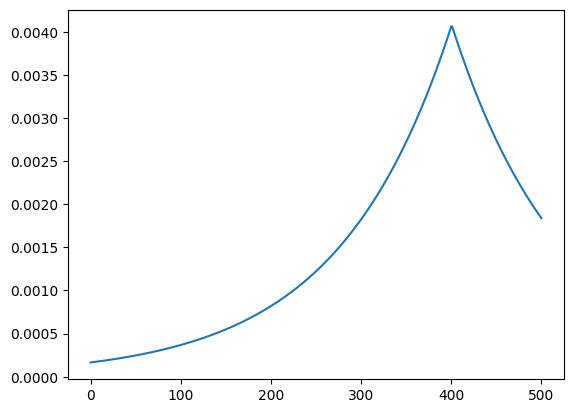

In [2113]:
rr = 0.2*np.zeros(500)
rr[400] = 1 # np.linspace(0, 2**12, 500)
conv = np.convolve(rr, de[0], 'valid')
print(conv.size, rr.size)
_ = plt.plot(conv)

In [2114]:
sr = xx[1] - xx[0]

In [2115]:
power = [np.abs(np.fft.rfft(x)) for x in de]
freqs = [np.fft.rfftfreq(x.size, sr) for x in de]

In [2116]:
decreasing_exponential(np.abs(np.linspace(-1000, 1000, 10_000)), 1).sum()

4.991175548143712

In [2117]:
def analytic_FT_decexp(σ, ω):
    return 1/((np.sqrt(2*np.pi))*(1 + (σ * ω)**2))

In [2209]:
rang = np.linspace(0, 100, 10_000)
anl_powers = [analytic_FT_decexp(i, rang) for i in range(1,10)]
# _ = [plt.plot(rang, ap, label=f"σ = {i}") for i in range(1,10)]
# _ = plt.legend()
# _ = plt.xlim(0.4, 2)

e_ix = 0
i_ix = 1
bs = calc_bs(param, 0.42, 0.2)  # u_bar == 0.42, v_bar == 0.2
σe = 1
e_ft = analytic_FT_decexp(1*σe, rang)
e_ft = e_ft/e_ft[0]
i2_ft = analytic_FT_decexp(2*σe, rang)
i2_ft = i2_ft/i2_ft[0]

i3_ft = analytic_FT_decexp(3*σe, rang)
i3_ft = i3_ft/i3_ft[0]

i5_ft = analytic_FT_decexp(5*σe, rang)
i5_ft = i5_ft/i5_ft[0]

i7_ft = analytic_FT_decexp(7*σe, rang)
i7_ft = i7_ft/i7_ft[0]

Dω2 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i2_ft) + bs[0,1]*bs[1,0]*e_ft*i2_ft
Dω3 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i3_ft) + bs[0,1]*bs[1,0]*e_ft*i3_ft
Dω5 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i5_ft) + bs[0,1]*bs[1,0]*e_ft*i5_ft
Dω7 = (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i7_ft) + bs[0,1]*bs[1,0]*e_ft*i7_ft
# Dω = Dω/Dω[0]
# Dω_iix = lambda i_ix: (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i_ft) + bs[0,1]*bs[1,0]*e_ft*i_ft

# Dωs = [Dω_iix(x) for x in range(2, 9)]
# Dωs = [d/d[0] for d in Dωs]

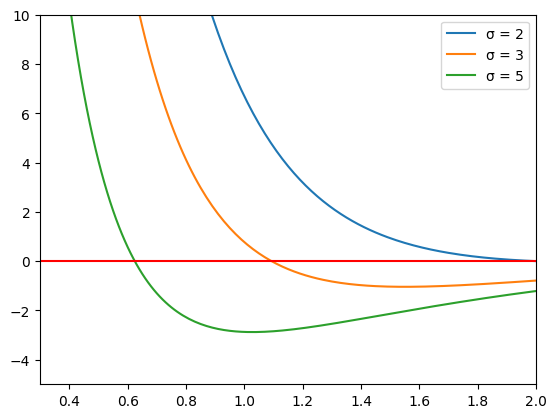

In [2210]:
_ = plt.plot(rang, Dω2, label=f"σ = 2")
_ = plt.plot(rang, Dω3, label=f"σ = 3")
_ = plt.plot(rang, Dω5, label=f"σ = 5")
# _ = plt.plot(rang, Dω7, label=f"σ = 7")
_ = plt.legend()
_ = plt.xlim(0.3, 2)
_ = plt.ylim(-5, 10)
_ = plt.hlines(0,0,100, color='r')

In [2197]:
e_ix = 0
i_ix = 2
bs = calc_bs(param, u_bar, v_bar)

Dω = (1 - bs[0,0]*power[e_ix])*(1 + bs[1,1]*power[i_ix]) + bs[0,1]*bs[1,0]*power[e_ix]*power[i_ix]
# Dω = Dω/Dω[0]
Dω_iix = lambda i_ix: (1 - bs[0,0]*power[e_ix])*(1 + bs[1,1]*power[i_ix]) + bs[0,1]*bs[1,0]*power[e_ix]*power[i_ix]

Dωs = [Dω_iix(x) for x in range(2, 9)]
# Dωs = [d/d[0] for d in Dωs]

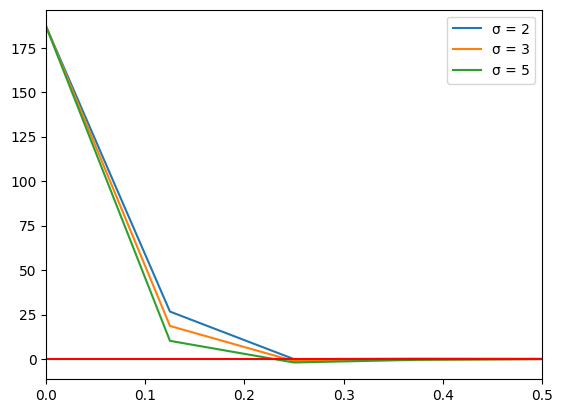

In [1931]:
_ = [plt.plot(freqs[0], Dωs[x].real, label=f"σ = {x+2}") for x in (0, 1, 3)]
_ = plt.legend()
plt.xlim(0, 0.5)
# plt.ylim(-5, 10)
plt.hlines(0, xmin=0, xmax=10, color=['r'])

(0.0, 2.0)

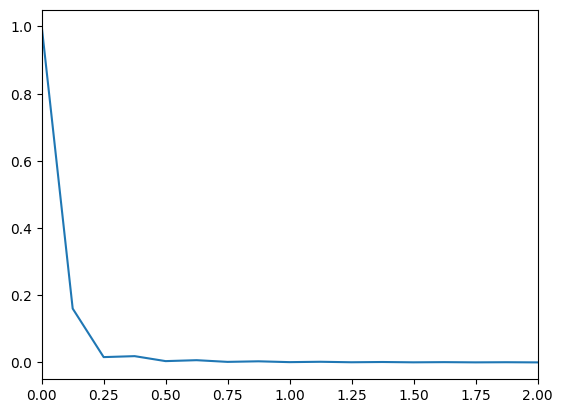

In [1728]:
plt.plot(freqs[0], power[4].real)
plt.xlim(0,2)

/home/nicolasjudd/.local/share/virtualenvs/py_projs-iE7mgdXD/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-1.0, 2.0)

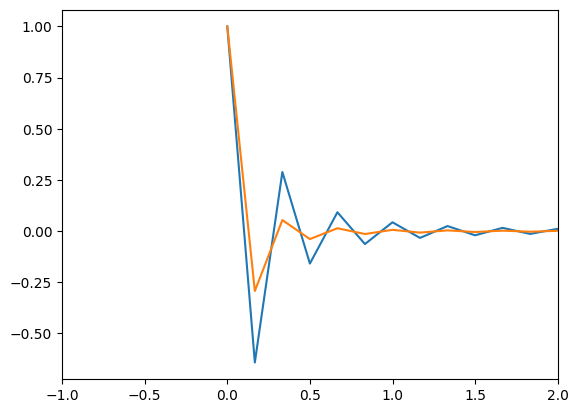

In [1528]:
ix = 2
plt.plot(freqs[ix], power[ix])
plt.plot(freqs[ix+5], power[ix+5])
plt.xlim(-1, 2)

array([[0.124949]])

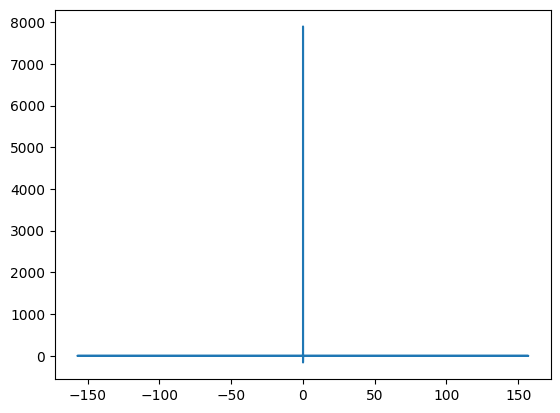

In [1427]:
sine = np.sin(1/8 * np.arange(0,8*np.pi* 100+1,0.01))
power = np.fft.rfft(sine)
freqs = np.fft.fftfreq(power.size, 1/(100*np.pi))

plt.plot(freqs, power)
freqs[np.argwhere(np.max(power) == power)]
# plt.xlim(0.1, 0.2)

In [293]:
opt.minimize(lambda inp: -1*parm_calc_D(inp[0], inp[1]), (0.4, 0.2))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -186.9374999998568
        x: [ 4.550e-01  2.200e-01]
      nit: 12
      jac: [-3.815e-06  7.629e-06]
 hess_inv: [[ 5.991e-06  4.566e-06]
            [ 4.566e-06  5.371e-06]]
     nfev: 57
     njev: 19

In [145]:
calc_D(param, 0.4, 0.2)

35.11828491144783